otimização de compra de produtos da cesta básica

### Instalação e carregamento das bibliotecas de GA em python

In [637]:
#!pip install deap
#!pip install openpyxl

In [638]:
import random
import numpy
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import math
import pandas as pd
from pesquisaCompras import gera_df_cesta_basica

# matriz para o calculo final dos custos da cesta básica
matrixCustoTotal = [[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]

# periodo total de compras para qtd de meses
periodo_compras = 1 

# O custo máximo que posso gastar no período, neste caso mensal.
custoMaximo = 800

#### Custo do frete de cada mercado, o frete fica gratuito se o custo do mercado for maior que o valor estimado por mercado, por exemplo no carrefour fica frete gratuito acima de R$200, caso o valor seja menor que R$200 será cobrado um frete de R$20

In [639]:
custoFrete = [[349,14.9],[1500,29.9],[399,25.9],[299,19.9],[199,24.9]]

#### Descontos apresentado por cada mercado, por exemplo, se o valor chegar a R$100 no Carrefour o cliente terá 5% de desconto em toda a compra (ainda não implementado)

In [640]:
descontosCarrefour = [(100,5),(200,10),(300,15)]
descontosZonaSul = [(80,5),(130,10)]
descontosPaoDeAcucar = [(100,10),(150,15)]
descontosPrezunic = [(100,3),(150,5)]
descontosHortifruti = [(80,5),(160,10),(240,15)]

#### É necessário fazer o upload dos dados dos 10 produtos da cesta básica, acompanhando seus preços em 5 mercados sendo:
1 - Carrefour
2 - Zona Sul
3 - Pão de Açucar
4 - Prezunic
5 - Hortifruti

In [641]:

#precos = gera_df_cesta_basica()
precos = pd.read_csv('precos_geral.csv')
precos

,Unnamed: 0,leguminosa,cereais,raizes,legumes,frutas,oleaginosas,carne,leite,oleos,cafe
0,Carrefour,5.598,6.49,3.890,5.580000,16.500000,5.99,11.89,34.225,5.69,29.98
1,Hortifruti,9.490,9.79,9.600,4.400000,12.466667,24.99,14.66,41.225,6.99,23.98
2,Pao de Acucar,5.998,8.99,5.500,10.290000,16.900000,146.60,18.90,44.475,6.89,35.98
3,Prezunic,6.890,8.09,11.580,9.190000,10.133333,25.40,16.09,45.975,6.89,39.18
4,Zona Sul,5.990,8.99,4.995,6.383333,5.995000,7.98,7.90,47.475,5.97,41.60


In [642]:
# carregando cada array com produtos e preços
#precos.to_csv('precos_geral.csv')
#produtos = precos.iloc[:,0:3]
carrefour = precos.iloc[:1,1:].values[0]
hortifruti = precos.iloc[1:2,1:].values[0]
pao_de_acucar = precos.iloc[2:3,1:].values[0]
prezunic = precos.iloc[3:4,1:].values[0]
zona_sul = precos.iloc[4:5,1:].values[0]

lista_qtd_mensal = [2, 4, 4, 2, 2, 0.5, 4, 4, 2, 2]
#lista_qtd_mensal
carrefour


array([ 5.598,  6.49 ,  3.89 ,  5.58 , 16.5  ,  5.99 , 11.89 , 34.225,
        5.69 , 29.98 ])

### Declaração das funções auxiliares que devem conter as informações do problema

In [643]:
# Função que calcula o custo para cada mercado
def CustoCestaPorMercado(individual):
  custoCarrefour = 0
  custoZona_sul = 0
  custoPao_de_acucar = 0
  custoPrezunic = 0
  custoHortifruti = 0
  custoNoMarket = 0
  qtdProdCarrefour = 0
  qtdProdSonaSul = 0
  qtdProdPaoDeAcucar = 0
  qtdProdPrezunic = 0
  qtdProdHortifruti = 0
  qtdNoMarket = 0
  # custo dos produtos
  #print(list(enumerate(zip(individual[0::2],individual[1::2]))))
  #for index,mercado in enumerate(individual[::2]):
  # formatando a lista para ter o mercado e a quantidade de produto na mesma iteração
  for index,cesta_mercado in enumerate(zip(individual[0::2],individual[1::2])):
    # Verificar o custo de cada produto no mercado
    mercado = cesta_mercado[0]
    qtd_prod = cesta_mercado[1]
    # custo por mercado
    if mercado == 1:
      custoCarrefour += float(carrefour[index]*qtd_prod)
      qtdProdCarrefour += qtd_prod
    elif mercado == 2:
      custoZona_sul += float(zona_sul[index]*qtd_prod)
      qtdProdSonaSul += qtd_prod
    elif mercado == 3:
      custoPao_de_acucar += float(pao_de_acucar[index]*qtd_prod)
      qtdProdPaoDeAcucar += qtd_prod
    elif mercado == 4:
      custoPrezunic += float(prezunic[index]*qtd_prod)
      qtdProdPrezunic += qtd_prod
    elif mercado == 5:
      custoHortifruti += float(hortifruti[index]*qtd_prod)
      qtdProdHortifruti += qtd_prod
    else:
      custoNoMarket += float(custoMaximo*qtd_prod)
      qtdNoMarket += qtd_prod
    #custoCarrefour += numpy.sum(float(carrefour.iloc[index].values*qtd_prod) if mercado == 1 else 0)
    #custoZona_sul += numpy.sum(float(zona_sul.iloc[index].values*qtd_prod) if mercado == 2 else 0)
    #custoPao_de_acucar += numpy.sum(float(pao_de_acucar.iloc[index].values*qtd_prod) if mercado == 3 else 0)
    #custoPrezunic += numpy.sum(float(prezunic.iloc[index].values*qtd_prod) if mercado == 4 else 0)
    #custoHortifruti += numpy.sum(float(hortifruti.iloc[index].values*qtd_prod) if mercado == 5 else 0)

    #qtdProdCarrefour += numpy.sum(float(qtd_prod) if mercado == 1 else 0)
    #qtdProdSonaSul += numpy.sum(float(qtd_prod) if mercado == 2 else 0)
    #qtdProdPaoDeAcucar += numpy.sum(float(qtd_prod) if mercado == 3 else 0)
    #qtdProdPrezunic += numpy.sum(float(qtd_prod) if mercado == 4 else 0)
    #qtdProdHortifruti += numpy.sum(float(qtd_prod) if mercado == 5 else 0)
  
  qtd_total_prod = qtdProdCarrefour+qtdProdSonaSul+qtdProdPaoDeAcucar+qtdProdPrezunic+qtdProdHortifruti
  '''
  # aplicando o desconto se atingir o custo para o Carrefour
  #descCarrefourReversed = list(reversed(descontosCarrefour))
  for desc in descontosCarrefour[::-1]:
    if desc[0]<=custoCarrefour:
        custoCarrefour = custoCarrefour * ((desc[1]-100)/100)
        break
  # aplicando o desconto se atingir o custo para o Zona Sul
  for valor, desc in descontosZonaSul[::-1]:
    if valor<=custoZona_sul:
        custoZona_sul = custoZona_sul * ((desc-100)/100)
        break
  # aplicando o desconto se atingir o custo para o Pão de Açucar
  for valor, desc in descontosPaoDeAcucar[::-1]:
    if valor<=custoPao_de_acucar:
        custoPao_de_acucar = custoPao_de_acucar * ((desc-100)/100)
        break
  # aplicando o desconto se atingir o custo para o Prezunic
  for valor, desc in descontosPrezunic[::-1]:
    if valor<=custoPrezunic:
        custoPrezunic = custoPrezunic * ((desc-100)/100)
        break
  # aplicando o desconto se atingir o custo para o Hortifruti
  for valor, desc in descontosHortifruti[::-1]:
    if valor<=custoHortifruti:
        custoHortifruti = custoHortifruti * ((desc-100)/100)
        break
  '''
  # ajustando ao custo do frete para o Carrefour
  if custoCarrefour < custoFrete[0][0] and custoCarrefour > 0:
      custoCarrefour += custoFrete[0][1]
  # ajustando ao custo do frete para o Zona Sul
  if custoZona_sul < custoFrete[1][0] and custoZona_sul > 0:
      custoZona_sul += custoFrete[1][1]    
  # ajustando ao custo do frete para o Pão de Açucar
  if custoPao_de_acucar < custoFrete[2][0] and custoPao_de_acucar > 0:
      custoPao_de_acucar += custoFrete[2][1] 
  # ajustando ao custo do frete para o Prezunic
  if custoPrezunic < custoFrete[3][0] and custoPrezunic >0:
      custoPrezunic += custoFrete[3][1] 
  # ajustando ao custo do frete para o Hortifruti
  if custoHortifruti < custoFrete[4][0] and custoHortifruti > 0:
      custoHortifruti += custoFrete[4][1] 
  
  return [custoCarrefour,custoZona_sul,custoPao_de_acucar,custoPrezunic,custoHortifruti,custoNoMarket],qtd_total_prod
  #return [custoCarrefour,custoZona_sul,custoPao_de_acucar,custoPrezunic,custoHortifruti],qtd_total_prod

In [644]:
# Função Objetivo -> Repare que o único parametro que a função deve receber é um individuo
def CustoCesta(individual):
  custoTotal = 0
  # recupera os custos por mercado
  listaCustos, qtd_tot_prod = CustoCestaPorMercado(individual)
  # custo dos produtos
  custoTotal = numpy.sum(listaCustos)

  return custoTotal,qtd_tot_prod

In [645]:
# Função que calcula a razão do custo x benefício para cada mercado - Função unificada
def CestasMercados(individual):
  custoCarrefour = 0
  custoZona_sul = 0
  custoPao_de_acucar = 0
  custoPrezunic = 0
  custoHortifruti = 0
  custoNoMarket = 0
  qtdProdCarrefour = 0
  qtdProdZonaSul = 0
  qtdProdPaoDeAcucar = 0
  qtdProdPrezunic = 0
  qtdProdHortifruti = 0
  qtdNoMarket = 0
  # custo dos produtos
  # formatando a lista para ter o mercado e a quantidade de produto na mesma iteração
  for index,cesta_mercado in enumerate(zip(individual[0::2],individual[1::2])):
    # Verificar o custo de cada produto no mercado
    mercado = cesta_mercado[0]
    qtd_prod = cesta_mercado[1]
    # custo por mercado
    if mercado == 1:
      custoCarrefour += float(carrefour[index]*qtd_prod)
      qtdProdCarrefour += qtd_prod
    elif mercado == 2:
      custoZona_sul += float(zona_sul[index]*qtd_prod)
      qtdProdZonaSul += qtd_prod
    elif mercado == 3:
      custoPao_de_acucar += float(pao_de_acucar[index]*qtd_prod)
      qtdProdPaoDeAcucar += qtd_prod
    elif mercado == 4:
      custoPrezunic += float(prezunic[index]*qtd_prod)
      qtdProdPrezunic += qtd_prod
    elif mercado == 5:
      custoHortifruti += float(hortifruti[index]*qtd_prod)
      qtdProdHortifruti += qtd_prod
    else:
      custoNoMarket += float(custoMaximo*qtd_prod)
      qtdNoMarket += qtd_prod
  
  #qtd_total_prod = qtdProdCarrefour+qtdProdZonaSul+qtdProdPaoDeAcucar+qtdProdPrezunic+qtdProdHortifruti

  # ajustando ao custo do frete para o Carrefour
  if custoCarrefour < custoFrete[0][0] and custoCarrefour > 0:
      custoCarrefour += custoFrete[0][1]
  # ajustando ao custo do frete para o Zona Sul
  if custoZona_sul < custoFrete[1][0] and custoZona_sul > 0:
      custoZona_sul += custoFrete[1][1]    
  # ajustando ao custo do frete para o Pão de Açucar
  if custoPao_de_acucar < custoFrete[2][0] and custoPao_de_acucar > 0:
      custoPao_de_acucar += custoFrete[2][1] 
  # ajustando ao custo do frete para o Prezunic
  if custoPrezunic < custoFrete[3][0] and custoPrezunic >0:
      custoPrezunic += custoFrete[3][1] 
  # ajustando ao custo do frete para o Hortifruti
  if custoHortifruti < custoFrete[4][0] and custoHortifruti > 0:
      custoHortifruti += custoFrete[4][1] 
  
  return [(custoCarrefour,qtdProdCarrefour),(custoZona_sul,qtdProdZonaSul),(custoPao_de_acucar,qtdProdPaoDeAcucar),(custoPrezunic,qtdProdPrezunic),(custoHortifruti,qtdProdHortifruti),(custoNoMarket,qtdNoMarket)]

In [646]:
def CustoBeneficioCesta(individual):
    custoBeneficioTotal = 0
    # recupera os custos por mercado
    cestas = CestasMercados(individual)
    # custo benefício de todos os mercados somados
    for custo,qtd in cestas:
        if custo == 0:
            custoBeneficioTotal += 0
        else:
            custoBeneficioTotal += qtd/custo

    return custoBeneficioTotal,

In [647]:
def CustoSoUmMercado(individual,mercado):
    custoMercado = 0
    if mercado == 1:
        for index,qtd_prod in enumerate(individual[1::2]):
            custoMercado += float(carrefour[index]*qtd_prod)
        if custoMercado < custoFrete[0][0] and custoMercado > 0:
            custoMercado += custoFrete[0][1]
    elif mercado == 2:
        for index,qtd_prod in enumerate(individual[1::2]):
            custoMercado += float(zona_sul[index]*qtd_prod)
        if custoMercado < custoFrete[1][0] and custoMercado > 0:
            custoMercado += custoFrete[1][1]
    elif mercado == 3:
        for index,qtd_prod in enumerate(individual[1::2]):
            custoMercado += float(pao_de_acucar[index]*qtd_prod)
        if custoMercado < custoFrete[2][0] and custoMercado > 0:
            custoMercado += custoFrete[2][1]
    elif mercado == 4:
        for index,qtd_prod in enumerate(individual[1::2]):
            custoMercado += float(prezunic[index]*qtd_prod)
        if custoMercado < custoFrete[3][0] and custoMercado > 0:
            custoMercado += custoFrete[3][1]
    else:
        for index,qtd_prod in enumerate(individual[1::2]):
            custoMercado += float(hortifruti[index]*qtd_prod)
        if custoMercado < custoFrete[4][0] and custoMercado > 0:
            custoMercado += custoFrete[4][1]

    return custoMercado

In [648]:
# Função para demonstrar o custo se comprar todas as mercadorias em um único mercado, para todos os mercados. 
# Assim, consegue verificar se a solução otimizada compensa ou não.
def DemonstraComparaCustosMercado(individual):

    custoOtimizado = 0
    qtd_total = 0 
    # custos se fosse tudo comprado no Carrefour
    custoCarrefour = CustoSoUmMercado(individual,1)
    # custos se fosse tudo comprado no Zona Sul
    custoZonaSul = CustoSoUmMercado(individual,2)
    # custos se fosse tudo comprado no Pão de Açucar
    custoPaoDeAcucar = CustoSoUmMercado(individual,3)
    # custos se fosse tudo comprado no Prezunic
    custoPrezunic = CustoSoUmMercado(individual,4)
    # custos se fosse tudo comprado no Hortifruti
    custoHortifruti = CustoSoUmMercado(individual,5)
    # recupera os custos por mercado
    cestas = CestasMercados(individual)
    # custo benefício de todos os mercados somados
    for custo,qtd in cestas:
        custoOtimizado += custo
        qtd_total +=qtd
    
    df_demostrativo = pd.DataFrame(columns=['mercado','custo','economia'])
    df_demostrativo.loc[len(df_demostrativo)] = ['Otimizado',custoOtimizado,0]
    df_demostrativo.loc[len(df_demostrativo)] = ['Carrefour',custoCarrefour,1-(custoOtimizado/custoCarrefour)]
    df_demostrativo.loc[len(df_demostrativo)] = ['Zona Sul',custoZonaSul,1-(custoOtimizado/custoZonaSul)]
    df_demostrativo.loc[len(df_demostrativo)] = ['Pão de Açucar',custoPaoDeAcucar,1-(custoOtimizado/custoPaoDeAcucar)]
    df_demostrativo.loc[len(df_demostrativo)] = ['Prezunic',custoPrezunic,1-(custoOtimizado/custoPrezunic)]
    df_demostrativo.loc[len(df_demostrativo)] = ['Hortifruti',custoHortifruti,1-(custoOtimizado/custoHortifruti)]
    
    return df_demostrativo,qtd_total

In [649]:
## Funcao para validar se é factivel
def eh_factivel(individual):
    
    # recupera o custo total, para comparar com o meu limite de compras do período
    custoTotal = CustoCesta(individual)[0]
    
    # nenhum produto pode ter qtd igual a zero
    for index,cesta_mercado in enumerate(zip(individual[0::2],individual[1::2])):
        # Verificar o custo de cada produto no mercado
        mercado = cesta_mercado[0]
        qtd_prod = cesta_mercado[1]
        if mercado > 5 or mercado < 1:
            return False
        if qtd_prod < 1:
            return False
        # nem mercado e nem a qtd de produtos podem ser zero e também não pode ser inferior a qtd mínima do produto no periodo
        if qtd_prod < (periodo_compras*lista_qtd_mensal[index]):
            return False
    if custoTotal <= custoMaximo and custoTotal > 0: 
         # verifica se comprando todas as mercadorias em um único mercado é mais economico ou não
        df_economia,qtd_total_prods = DemonstraComparaCustosMercado(individual)
        for econ in df_economia['economia']:
            if econ < 0:
                return False
    else:
        return False
    return True

In [650]:
## Funcao de Penalização
def penalidade(individual):
    # recupera o custo total, para comparar com o meu limite de compras do período
    custoTotal,qtd_prod = CustoCesta(individual)
    custo_penalidade = 0
    #if custoTotal > custoMaximo:
    custo_penalidade = abs(custoMaximo-custoTotal)**3
    #custo_penalidade = (custoTotal+custoMaximo)**2
    #custo_penalidade = custoMaximo-(custoTotal+custoMaximo)**2
    '''
    for index,cesta_mercado in enumerate(zip(individual[0::2],individual[1::2])):
        # Verificar o custo de cada produto no mercado
        mercado = cesta_mercado[0]
        qtd_prod = cesta_mercado[1]
        if mercado == 0 or qtd_prod == 0:
            custo_penalidade = (custoTotal+custoMaximo)**10
    
    return custo_penalidade, 0.0
    '''
    if eh_factivel(individual):
        return custoTotal,qtd_prod
    else:
        return custo_penalidade+custoTotal, qtd_prod

In [651]:
## Funcao de Penalização, utilizando o custo benefício
def penalidadeCustoBeneficio(individual):
    # recupera o custo total, para comparar com o meu limite de compras do período
    custo_penalidade = 0
    qtd_penalidade = 0
    #cestas = CestasMercados(individual)
    # custo benefício de todos os mercados somados
    #for custo,qtd in cestas:
    #    qtd_penalidade += qtd
    #    custo_penalidade += custo
    custoBeneficioCesta = CustoBeneficioCesta(individual)
    #custo_penalidade = (custo_penalidade+custoMaximo)

    if eh_factivel(individual):
        return custoBeneficioCesta[0],
    else:
        return custoBeneficioCesta[0] - (1+custoBeneficioCesta[0])**2, #custoMaximo, #custo_penalidade, 

In [652]:
# Função para gerar o indivíduo com as condições especificadas
def custom_individual():
    individual = creator.Individual() 
    for i in range(20):  # Tamanho 20
        if i % 2 == 0:  # Índices pares, identificador do mercado
            individual.append(random.randint(1, 5))
        else:  # Índices ímpares, quantidade de produtos para as mercadorias
            individual.append(random.randint(1, 10))
    return individual

In [653]:
# Função para gerar o indivíduo específico somente para um mercado
def custom_seeds_individual():
    seeds = []
    seed_random = [3, 10, 5, 10, 1, 10, 5, 10, 2, 9, 2, 10, 2, 10, 5, 4, 4, 10, 5, 2]
                  
    for merc in range(5):
        individual = creator.Individual() 
        #for i in range(20):  # Tamanho 20
        for index,elem in enumerate(seed_random):
            #if i % 2 == 0:
            if index % 2 == 0:  # Índices pares, identificador do mercado
                individual.append(merc+1)
            else:  # Índices ímpares, quantidade de produtos para as mercadorias
                #individual.append(random.randint(1, 10))
                individual.append(elem)
        seeds.append(individual)
    return seeds

In [654]:
# Função Crossover, para tentar variar os tipo de crossover
def CrossoverFunction(ind1, ind2, individualGenerator):
  # crossover em dois blocos dos indivíduos
  new_ind1, new_ind2 = tools.cxTwoPoint(ind1, ind2)
  # validando o novo indivíduo 1 gerado
  if(not(eh_factivel(new_ind1))):
    # crossover em um bloco dos indivíduos
    new_ind1,_ = tools.cxOnePoint(ind1, ind2)
    if(not(eh_factivel(new_ind1))):
      # crossover na base da probabilidade tx de 70%
      new_ind1,_ = tools.cxUniform(ind1, ind2, indpb=0.5)
      if(not(eh_factivel(new_ind1))):
        tries = 0
        while(not(eh_factivel(new_ind1))):
          if tries >= 100:
            new_ind1 = ind1
            break
          new_ind1 = custom_individual()
          tries = tries + 1
  # validando o novo indivíduo 2 gerado
  if(not(eh_factivel(new_ind2))):
    # crossover em um bloco dos indivíduos
    _,new_ind2 = tools.cxOnePoint(ind1, ind2)
    if(not(eh_factivel(new_ind2))):
      # crossover na base da probabilidade tx de 70%
      _,new_ind2 = tools.cxUniform(ind1, ind2, indpb=0.5)
      if(not(eh_factivel(new_ind2))):
        tries = 0
        while(not(eh_factivel(new_ind2))):
          if tries >= 100:
            new_ind2 = ind2
            break
          new_ind2 = custom_individual()
          tries = tries + 1
  return new_ind1,new_ind2

In [ ]:
# Função de mutação, para tentar variar os tipo de mutação
def MutationFunction(individual):
  # mutação de embaralhamento de indices, 50% de probabilidade de haver intercambio de posições
  new_ind1, = tools.mutShuffleIndexes(individual, indpb=0.5)
  # validando o novo indivíduo gerado
  if(not(eh_factivel(new_ind1))):
    # mutação de um individua usando mutUniformInt, onde indpb=50%
    new_ind1, = tools.mutUniformInt(individual, low=1, up=10, indpb=0.5)
    if(not(eh_factivel(new_ind1))):
      # mutação de embaralhamento de indices, 70% de probabilidade de haver intercambio de posições
      new_ind1, = tools.mutShuffleIndexes(individual, indpb=0.7)
      if(not(eh_factivel(new_ind1))):
        tries = 0
        while(not(eh_factivel(new_ind1))):
          if tries >= 100:
            new_ind1 = individual
            break
          new_ind1 = custom_individual()
          tries = tries + 1
  return new_ind1,

### Declaração dos pacotes referentes a biblioteca do GA: 
#### Nomenclatura referente a biblioteca e deve-se alterar somente os pesos das funções que deverão ser, ou maximizada ou minimizada
#### Pode-se alterar também o tipo da variavel do Individuo. Mas que, geralmente, é uma lista de numeros inteiros

In [656]:
# fitness maximiza objetivo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

c:\ProgramsNokia\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\ProgramsNokia\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [657]:
#mercados = numpy.random.choice(range(1,6), size=10,  replace=True)
#qtd_prod = numpy.random.choice(range(1,11), size=10,  replace=True)
mercado_min = 1
mercado_max = 5
qtd_prod_min = 1
qtd_prod_max = 10

In [658]:
toolbox = base.Toolbox()
# Definir o gerador de numeros inteiros aleatórios de (1 a 5) para os mercados.
# Definir o gerador de numeros inteiros aleatórios de (1 a 10) para a qtd de produtos.
#toolbox.register("random_int_mercado", random.randint, mercado_min, mercado_max)
#toolbox.register("random_int_qtd_prod", random.randint, qtd_prod_min, qtd_prod_max)
# Inicialização do cromossomo (quantos genes o cromossomo deve possuir)
#toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.random_int_mercado,toolbox.random_int_qtd_prod), n=10)
toolbox.register("individual", tools.initIterate, creator.Individual, custom_individual)
# Registro do individuo na população
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Registro do nome da função objetivo
#toolbox.register("evaluate", penalidade)
toolbox.register("evaluate", penalidadeCustoBeneficio)

#################################### OPERADORES ####################################
## Registro de qual o tipo de cruzamento deve ser utilizado (cruzamento de 2 pontos)
#toolbox.register("mate", tools.cxTwoPoints) 
#toolbox.register("mate", tools.cxUniform, indpb=0.2)
toolbox.register("mate", CrossoverFunction, individualGenerator=toolbox.individual)
## Registro da função de penalidade caso o individuo não obedeça as restrições
#toolbox.register("evaluate", tools.DeltaPenalty(restricao, penalidade, CustoCesta))
## Registro de qual tipo de mutação deve ser utilizado (probabilidade de um individuo sofrer mutação)
#toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.4)
toolbox.register("mutate", MutationFunction)
## Registro de qual o tipo do método de seleção que será utilizado
toolbox.register("select", tools.selTournament, tournsize=10)
#toolbox.register("select", tools.selNSGA2)
#toolbox.register("select", tools.selRoulette)

## Chamada efetiva do GA para resolução

In [659]:
# inicialização da pop
pop = toolbox.population(n=200)                           
# incluindo sementes de indivíduos que são específicos e apenas um emrcado
pop.extend(custom_seeds_individual())
# melhor indivíduo
hof = tools.HallOfFame(1)                                 
#stats_func1 = tools.Statistics(key=lambda ind: ind.fitness.values[0::2])
#stats_func2 = tools.Statistics(key=lambda ind: ind.fitness.values[1::2])
#stats = tools.MultiStatistics(func1=stats_func1, func2=stats_func2)
#stats.register("avg", numpy.mean)
#stats.register("std", numpy.std)
#stats.register("min", numpy.min)
#stats.register("max", numpy.max)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", lambda x: tuple(map(lambda y: sum(y) / len(y), zip(*x))))
stats.register("min", lambda x: tuple(map(min, zip(*x))))
stats.register("max", lambda x: tuple(map(max, zip(*x))))

In [660]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.7, ngen=200, stats=stats, halloffame=hof, verbose=True) #aumentei mut = 0.7
#pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=50, lambda_=50, cxpb=0.8, mutpb=0.2, ngen=300, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg                   	min                  	max                   
0  	205   	(-1.3766671987900538,)	(-1.678988797691182,)	(0.10669813215505122,)
1  	189   	(-1.2674823983110766,)	(-1.6134531623955262,)	(0.3278986117587035,) 
2  	180   	(-1.2152169889943012,)	(-1.5939408478122594,)	(0.3278986117587035,) 
3  	193   	(-1.2144793572355923,)	(-1.5971455656234395,)	(0.3278986117587035,) 
4  	192   	(-1.1994027321312517,)	(-1.7155854946885132,)	(0.3278986117587035,) 
5  	184   	(-1.1503851399347453,)	(-1.6941512163224957,)	(0.33380214688072357,)
6  	186   	(-1.1630807517541737,)	(-1.6455353257558138,)	(0.338451652256254,)  
7  	183   	(-1.101954764911211,) 	(-1.8247929808396215,)	(0.42131824936289064,)
8  	178   	(-0.9821134156810764,)	(-1.6560401956842368,)	(0.42131824936289064,)
9  	181   	(-0.8442548966903014,)	(-1.5975550424153566,)	(0.423730166241104,)  
10 	190   	(-0.8187861822162567,)	(-1.7375291567703148,)	(0.4463479285319136,) 
11 	181   	(-0.7835758463737497,)	(-1.8075

## Resultados

In [661]:
# Melhor solução
print("Melhor Indivíduo:")
print(hof[0])

# Verificação da função de restrição
print(eh_factivel(hof[0]))
#print(penalidade(hof[0]))
print(penalidadeCustoBeneficio(hof[0]))


# Melhor resultado da função objetivo
print("Melhor Resultado da Função Objetivo:")
#CustoCesta(hof[0])
CustoBeneficioCesta(hof[0])
df,qtd_total = DemonstraComparaCustosMercado(hof[0])
print('Quantidade Total de produtos: '+str(qtd_total))
df


Melhor Indivíduo:
[4, 10, 4, 9, 1, 7, 5, 10, 2, 10, 1, 7, 2, 9, 5, 4, 3, 9, 5, 3]
True
(0.5650738889437893,)
Melhor Resultado da Função Objetivo:
Quantidade Total de produtos: 78


,mercado,custo,economia
0,Otimizado,775.370000,0.000000
1,Carrefour,789.410000,0.017785
2,Zona Sul,824.848333,0.059985
3,Pão de Açucar,1995.440000,0.611429
4,Prezunic,1102.063333,0.296438
5,Hortifruti,1025.496667,0.243908


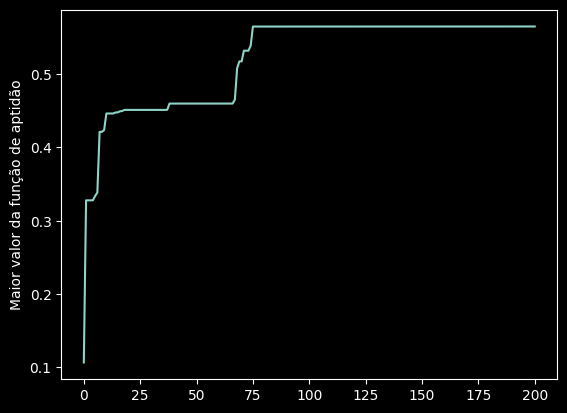

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200] [(0.10669813215505122,), (0.3278986117587035,), (0.3278986117587035,), (0.3278986117587035,), (0.3278986

In [662]:
import matplotlib.pyplot as plt
gen, maxVal = log.select("gen", "max")
plt.plot(gen, maxVal)
plt.ylabel('Maior valor da função de aptidão')
plt.show()
print(gen, maxVal)

In [663]:
epochs_avg = [value for epoch_kv in log for key,value in epoch_kv.items() if key == 'avg']
epochs_max = [value for epoch_kv in log for key,value in epoch_kv.items() if key == 'max']
epochs_min = [value for epoch_kv in log for key,value in epoch_kv.items() if key == 'min']

In [664]:
epochs_best = []
for epoch_kv in log:
  for key,value in epoch_kv.items():
    if key == 'max':
      if len(epochs_best) == 0 or value > epochs_best[-1]:
        epochs_best.append(value)
      else:
        epochs_best.append(epochs_best[-1])

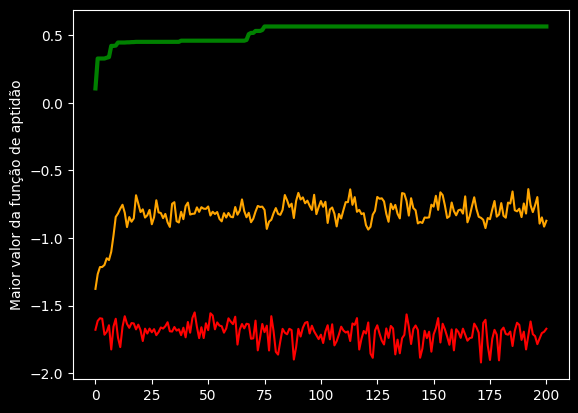

In [665]:
from matplotlib import style
style.use('dark_background')
import matplotlib.pyplot as plt
plt.plot(epochs_max, color='blue')
plt.plot(epochs_avg, color='orange')
plt.plot(epochs_min, color='red')
plt.plot(epochs_best, color='green', linewidth=3)
plt.ylabel('Maior valor da função de aptidão')
plt.show()